In [1]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np

### Data set-up

In [4]:
def get_sara():
    return ir_datasets.load('sara')

def sara_docs():
    for doc in sara_dataset.docs_iter():
        doc_id = doc.doc_id
        text = doc.text
        sens = doc.sensitivity
        text_method = doc.default_text()
        
        e = email.message_from_string(text_method)
        pl = e.get_payload()

        print(doc_id, sens)
        break

def dataset_to_df(sara_dataset):
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df

#sara_dataset = get_sara()
#sara_df = dataset_to_df()

In [5]:
def get_sample_n(data, n):
    return data.sample(n=n, random_state=1)

def get_sample_frac(data, frac):
    return data.sample(frac=frac, random_state=1)

#d = get_sample_n(sara_df, 2)
#d

### Pre-processing

Preprocessing 1 - Separating replies using Original Message and Forwarded tags.

In [6]:
def proc1(dataset):
    def get_orig(message, find_orig_message):
        #line_start = message.rfind('\n', 0, find_orig_message)
        line_start = find_orig_message
        base_message = message[:line_start]
        line_end = find_orig_message + 5 #message.find('\n', find_orig_message)
        orig_message = message[line_end:]
        return base_message, orig_message

    def get_separate_messages(message):
        payload = message.split('\r\n\r\n')[1]
        separate_messages = []

        find_fwd_message = payload.find('\n----- Forw')
        find_orig_message = payload.find('-----Original Message-')
        
        n = payload
        while (find_fwd_message > 0 or find_orig_message > 0):
            if (find_fwd_message > 0 and find_orig_message > 0):
                if find_fwd_message < find_orig_message:
                    b, n = get_orig(n, find_fwd_message)
                else:
                    b, n = get_orig(n, find_orig_message)
            elif (find_fwd_message > 0 and find_orig_message < 0):
                b, n = get_orig(n, find_fwd_message)
            else:
                b, n = get_orig(n, find_orig_message)
            
            find_fwd_message = n.find('\n----- Forw')
            find_orig_message = n.find('-----Original Message-')

            b = re.sub(r'\s+', ' ', b)
            separate_messages.append(b)

        n = re.sub(r'\s+', ' ', n)
        separate_messages.append(n)

        return separate_messages

    def preprocessing_dataframe(testing_sample):
        ids = []
        texts = []
        sens = []
        preproc = {}

        for s in testing_sample.iterrows():
            separate_messages = get_separate_messages(s[1].text)

            if len(separate_messages) == 1:
                ids.append(s[1].doc_id)
                texts.append(separate_messages[0])
                sens.append(s[1].sensitivity)
            else:
                for i, m in enumerate(separate_messages):
                    id_part = s[1].doc_id + '_' + str(i)
                    ids.append(id_part)
                    texts.append(m)
                    sens.append(s[1].sensitivity)

        preproc['doc_id'] = ids
        preproc['text'] = texts
        preproc['sensitivity'] = sens
        return preproc

    def get_preprocessed_sara_replies(dataset):
        preproc = preprocessing_dataframe(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    return get_preprocessed_sara_replies(dataset)


Preprocessing 2 - Separating paragraphs. Each paragraph is treated as a separate document. 
- Where double newline exists. Also found some areas with '\n whitespace \n' that has been replaced.
- As reply headers cannot be cleaned easily, the paragraph with To for example could be removed as this should just be the header. Likewise with empty documents. 
- The smallest ~1000 documents have length less than 20: these are usually letters/punctuation/name sign offs - these are less informative or useful in identifying the sensitivity of the information, so have been removed for simplicity in this preprocessing strategy.

In [7]:
def proc2(dataset):    
    def process_text(input_text):
        clean = input_text
        clean = re.sub(r'=20', ' ', clean)
        clean = re.sub(r'=09', ' ', clean)
        # Also > Whitespace1+ > 
        clean = re.sub(r'\n\>', '\n', clean)
        clean = re.sub(r'\n\n\t', '\n', clean)
        # Replace whitespace between two newline characters with a single newline
        #cleaned_text = re.sub(r'\n\s*\n', '\n\n', input_text)
        #clean = re.sub(r'\n \n', '\n\n', clean)
        clean = re.sub(r'\n \n', '\n', clean)
        return clean

    def get_separate_paras(doc):
        paras = []
        payload = doc.split('\r\n\r\n')[1]
        payload = process_text(payload)
        split_load = payload.split('\n\n')
        for m in split_load:
            #if 'Subject:' in t:
            #    continue
            if 'To:' in m or 'From:' in m or 'mailto' in m or m == '':
                continue
            if len(m) < 2:
                continue
            if len(m) < 20:
                continue
            
            m = re.sub(r'\s+', ' ', m)
            paras.append(m)
        return paras

    def preproc(sample):
        sep_docs = []
        sep_docs_ids = []
        sep_docs_sens = []
        i = 0
        for s in sample.iterrows():

            separate_messages = get_separate_paras(s[1].text)
            for i, m in enumerate(separate_messages):
                id_part = s[1].doc_id + '_' + str(i)
                sep_docs_ids.append(id_part)
                sep_docs.append(m)
                sep_docs_sens.append(s[1].sensitivity)

        preproc = {}
        preproc['doc_id'] = sep_docs_ids
        preproc['text'] = sep_docs
        preproc['sensitivity'] = sep_docs_sens
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    def get_preprocessed_sara_paras(dataset):
        preproc_data = preproc(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc_data)
        return preproc_df

    return get_preprocessed_sara_paras(dataset)

Preprocessing 3

In [9]:
def proc3(dataset):
    def get_orig(message, find_orig_message):
        #line_start = message.rfind('\n', 0, find_orig_message)
        line_start = find_orig_message
        base_message = message[:line_start]
        line_end = find_orig_message + 5 #message.find('\n', find_orig_message)
        orig_message = message[line_end:]
        #print('split out')
        # Clean orig message
        if 'Subject' in orig_message:
            #print(1111)
            #print(orig_message)
            over_header = orig_message.find('Subject:')
            orig_message = orig_message[over_header:]
            #print('Clean')
            #print(orig_message)
            #exit(1)
        return base_message, orig_message

    def get_separate_messages(message):
        payload = message.split('\r\n\r\n')[1]
        separate_messages = []

        find_fwd_message = payload.find('- Forw')
        find_orig_message = payload.find('-----Original Message-')
        
        n = payload
        while (find_fwd_message > 0 or find_orig_message > 0):
            if (find_fwd_message > 0 and find_orig_message > 0):
                if find_fwd_message < find_orig_message:
                    b, n = get_orig(n, find_fwd_message)
                else:
                    b, n = get_orig(n, find_orig_message)
            elif (find_fwd_message > 0 and find_orig_message < 0):
                b, n = get_orig(n, find_fwd_message)
            else:
                b, n = get_orig(n, find_orig_message)
            
            find_fwd_message = n.find('- Forw')
            find_orig_message = n.find('-----Original Message-')

            b = re.sub(r'\s+', ' ', b)
            separate_messages.append(b)

        n = re.sub(r'\s+', ' ', n)
        if 'Subject' in n:
            over_header = n.find('Subject:')
            n = n[over_header:]
        separate_messages.append(n)

        return separate_messages

    def preprocessing_dataframe(testing_sample):
        ids = []
        texts = []
        sens = []
        preproc = {}

        for s in testing_sample.iterrows():
            separate_messages = get_separate_messages(s[1].text)

            if len(separate_messages) == 1:
                ids.append(s[1].doc_id)
                texts.append(separate_messages[0])
                sens.append(s[1].sensitivity)
            else:
                for i, m in enumerate(separate_messages):
                    id_part = s[1].doc_id + '_' + str(i)
                    ids.append(id_part)
                    texts.append(m)
                    sens.append(s[1].sensitivity)

        preproc['doc_id'] = ids
        preproc['text'] = texts
        preproc['sensitivity'] = sens
        return preproc

    def get_preprocessed_sara_p3(dataset):
        preproc = preprocessing_dataframe(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    return get_preprocessed_sara_p3(dataset)

In [10]:
sara_dataset = get_sara()
sara_df = dataset_to_df(sara_dataset)
proc_samp1 = proc1(sara_df)
proc_samp2 = proc2(sara_df)
proc_samp3 = proc3(sara_df)
proc_samp1.head()
proc_samp3.head()

,doc_id,text,sensitivity
0,114715_0,Though I had a somewhat different notion when ...,0
1,114715_1,"Subject: Possible co-sponsorships > > Rob, I'd...",0
2,229405_0,"FYI, the attached article and story is disturb...",0
3,229405_1,"Subject: FW: website FYI, This article recentl...",0
4,229405_2,Subject: website This is the Dateline website ...,0


In [ ]:
#for p in proc_samp3.text:
    #print(p)

In [13]:
idd = proc_samp3.doc_id[0][:6]
i = 0
for m in proc_samp3.iterrows():
    if m[1].doc_id[:6] == idd:
        i += 1
        print('MESSAGE PART', i)
        print(m[1].text)
        print()

MESSAGE PART 1
Though I had a somewhat different notion when I initially raised the idea of co-sponsorship, I agree with Lee's observations and think that we should proceed the way he suggests. gramlr@pjm.com on 08/29/2000 04:06:56 PM To: whederman@columbiaenergygroup.com, doornbos@socrates.berkeley.edu, amosher@appanet.org, hcameron@uclink.berkeley.edu, lfried@uclink.berkeley.edu, jeff.dasovich@enron.com cc: Subject: FW: Possible co-sponsorships All, Lee asked me to forward this. I'm still awaiting additional suggestions from anyone on speakers. I guess Lee's e-mail changes things. If the business school wants to go forward with a conference anyway then it may be a bad idea to have a separate one. Jeff has said he likes the idea of coordinating. Bill and Allen, what do you think? I will chime in that Carl Shapiro is very much a big wig, as a former chief economist at DOJ. As for the Frank Wolak suggestion, Frank is a Stanford economist who is an outstanding analyst and has published p

In [14]:
idd = proc_samp1.doc_id[0][:6]
i = 0
for m in proc_samp1.iterrows():
    if m[1].doc_id[:6] == idd:
        i += 1
        print('MESSAGE PART', i)
        print(m[1].text)
        print()

MESSAGE PART 1
Though I had a somewhat different notion when I initially raised the idea of co-sponsorship, I agree with Lee's observations and think that we should proceed the way he suggests. gramlr@pjm.com on 08/29/2000 04:06:56 PM To: whederman@columbiaenergygroup.com, doornbos@socrates.berkeley.edu, amosher@appanet.org, hcameron@uclink.berkeley.edu, lfried@uclink.berkeley.edu, jeff.dasovich@enron.com cc: Subject: FW: Possible co-sponsorships All, Lee asked me to forward this. I'm still awaiting additional suggestions from anyone on speakers. I guess Lee's e-mail changes things. If the business school wants to go forward with a conference anyway then it may be a bad idea to have a separate one. Jeff has said he likes the idea of coordinating. Bill and Allen, what do you think? I will chime in that Carl Shapiro is very much a big wig, as a former chief economist at DOJ. As for the Frank Wolak suggestion, Frank is a Stanford economist who is an outstanding analyst and has published p

### Llama 2 with SARA

In [23]:
def get_llama2(name):
    access_token = l2_token
    model_name = name
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=access_token)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", token=access_token, cache_dir=my_cache)
    return tokenizer, model

def get_model_version(m, v):
    models_dict = {'get_llama2' : get_llama2}
    return models_dict.get(m)(v)

#tokenizer, model = get_model_version('get_llama2', "TheBloke/Llama-2-7B-Chat-GPTQ")

In [24]:
def llm_inference(document, prompt, model, tokenizer):
  inputs = tokenizer(prompt(document), return_tensors='pt')
  generation_config = GenerationConfig(
    # Unable to set temperature to 0 - https://github.com/facebookresearch/llama/issues/687 - use do_sample=False for greedy decoding
    do_sample=False,
    max_new_tokens=20,
  )
  output = model.generate(inputs=inputs.input_ids.cuda(), attention_mask=inputs.attention_mask.cuda(), generation_config=generation_config)
  return tokenizer.decode(output[0], skip_special_tokens=True)

def display_gen_text(output, prompt_end):
  end_template = output.find(prompt_end) # Only return new generated text
  return output[end_template:]

def prompt_to_reply(d, p, model, tokenizer, end):
  response = llm_inference(d, p, model, tokenizer)
  return display_gen_text(response, end)


# String matching on model response
def post_process_classification(classification, ground_truth):
    if 'non-sensitive' in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    elif 'sensitive' in classification.lower() and 'non-sensitive' not in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification


def clear_memory():
    # Prevents cuda out of memory
    torch.cuda.empty_cache()
    gc.collect()


# Dataset - dataframe, prompt_strategy - prompt function name
def llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    further_processing_required = {}
    # All model output
    model_responses = {}

    scikit_true = []
    scikit_pred = []

    for sample in dataset.iterrows():
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # To replace with appropriate pre-processing
        if len(sample_text) > 12000:
            continue
        
        classification = prompt_to_reply(sample_text, prompt_strategy, model, tokenizer, end_prompt)
        model_responses[sample[1].doc_id] = classification

        quadrant, pred = post_process_classification(classification, ground_truth)
        if pred == None:
            further_processing_required[sample[1].doc_id] = quadrant
            continue

        predictions[quadrant] = predictions.get(quadrant) + 1
        scikit_true.append(ground_truth)
        scikit_pred.append(pred)

        clear_memory()

    return predictions, further_processing_required, model_responses, scikit_true, scikit_pred


#predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(sara_df, prompt_strategy, end)

In [ ]:
def post_process_split_docs(mr, fpr, pre):
    clean_doc_id = {}
    ground_truths = []
    ite = -1
    for s in mr.keys(): #samp.doc_id():
        if s in fpr.keys():
            continue

        if '_' in s:
            s = s[:s.find('_')]

        val = clean_doc_id.get(s, -1)
        ite += 1

        if val == -1:

            clean_doc_id[s] = pre[ite]
            #print(val)
            ground_truths.append((sara_df[sara_df.doc_id == s].sensitivity).iloc[0])
            continue

        if (val == pre[ite] or val == 1):
            continue
        
        clean_doc_id[s] = pre[ite]

    values_array = np.array(list(clean_doc_id.values()))
    return values_array, ground_truths

### Evaluation summary

In [25]:
def basic_metrics(true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    bac = balanced_accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average=None)


def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()

def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    print(metric_dict)

 
#evaluation_summary("Llama-2", scikit_true, scikit_pred)

### ML methods

#### Dummy classifiers

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)

In [15]:
def dummys(train, test):
    vectorizer = CountVectorizer()
    vectorizer.fit(train.text.tolist())

    train_features = vectorizer.transform(train.text.tolist())
    test_features = vectorizer.transform(test.text.tolist())
    train_labels = train.sensitivity
    test_labels = test.sensitivity

    dummy_mf = DummyClassifier(strategy="most_frequent")
    dummy_mf.fit(train_features, train_labels)
    mf_test_preds = dummy_mf.predict(test_features)
    evaluation_summary("Dummy MF", test_labels, mf_test_preds)


    dummy_rand = DummyClassifier(strategy="stratified")
    dummy_rand.fit(train_features, train_labels)
    rand_test_preds = dummy_rand.predict(test_features)
    evaluation_summary("Dummy Random stratified sampling", test_labels, rand_test_preds)

    return mf_test_preds, rand_test_preds


#dummys(training_data, testing_sample)

#### Logistic regression and SVM - with TF-IDF

In [16]:
def lr_svm_tdidf(train, test):
    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(train.text.tolist())
    test_tfidf = tfidf_vectoizer.transform(test.text.tolist())

    lr = LogisticRegression(max_iter=500)
    lr.fit(train_tfidf, train.sensitivity)
    lr_preds = lr.predict(test_tfidf)
    evaluation_summary("LR", test.sensitivity, lr_preds)

    svm_model = SVC()
    svm_model.fit(train_tfidf, train.sensitivity)
    svm_preds = svm_model.predict(test_tfidf)
    evaluation_summary("SVM", test.sensitivity, svm_preds)

    return lr_preds, svm_preds

#### Results - ML and L2

In [ ]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)
value_counts = testing_sample.sensitivity.value_counts()

'''
doc_lengths = testing_sample.text.str.len()
cannot_load = testing_sample[doc_lengths > 12000]
value_counts = cannot_load.sensitivity.value_counts()
'''

doc_lengths = testing_sample.text.str.len()
temp_testing_sample = testing_sample[doc_lengths < 12000]
testing_sample = temp_testing_sample

sampled_indices = testing_sample.index
training_data = sara_df.drop(sampled_indices)

Evaluation for: Dummy MF
                   precision    recall  f1-score   support

Non-sensitive (0)      0.897     1.000     0.946       305
    Sensitive (1)      0.000     0.000     0.000        35

         accuracy                          0.897       340
        macro avg      0.449     0.500     0.473       340
     weighted avg      0.805     0.897     0.848       340



Confusion matrix:


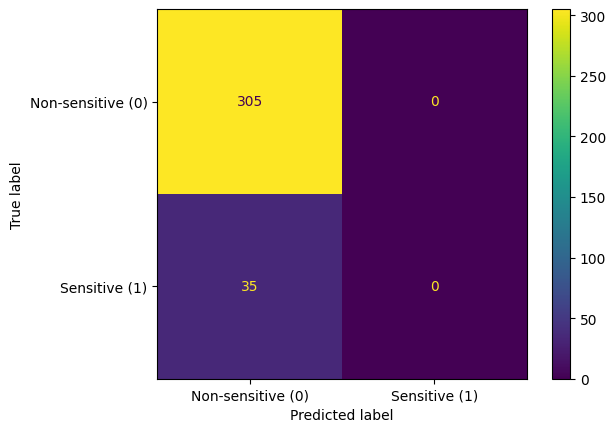

Evaluation for: Dummy Random stratified sampling
                   precision    recall  f1-score   support

Non-sensitive (0)      0.898     0.892     0.895       305
    Sensitive (1)      0.108     0.114     0.111        35

         accuracy                          0.812       340
        macro avg      0.503     0.503     0.503       340
     weighted avg      0.816     0.812     0.814       340



Confusion matrix:


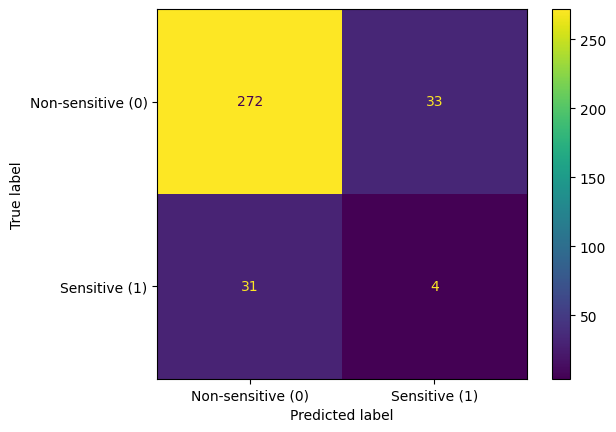

Evaluation for: LR
                   precision    recall  f1-score   support

Non-sensitive (0)      0.913     0.993     0.951       305
    Sensitive (1)      0.750     0.171     0.279        35

         accuracy                          0.909       340
        macro avg      0.831     0.582     0.615       340
     weighted avg      0.896     0.909     0.882       340



Confusion matrix:


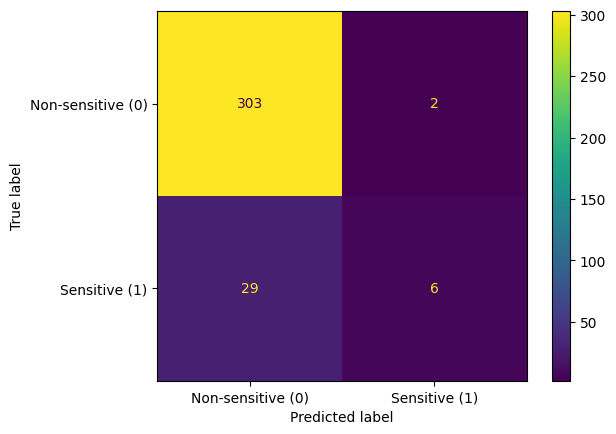

Evaluation for: SVM
                   precision    recall  f1-score   support

Non-sensitive (0)      0.918     0.990     0.953       305
    Sensitive (1)      0.727     0.229     0.348        35

         accuracy                          0.912       340
        macro avg      0.823     0.609     0.650       340
     weighted avg      0.898     0.912     0.890       340



Confusion matrix:


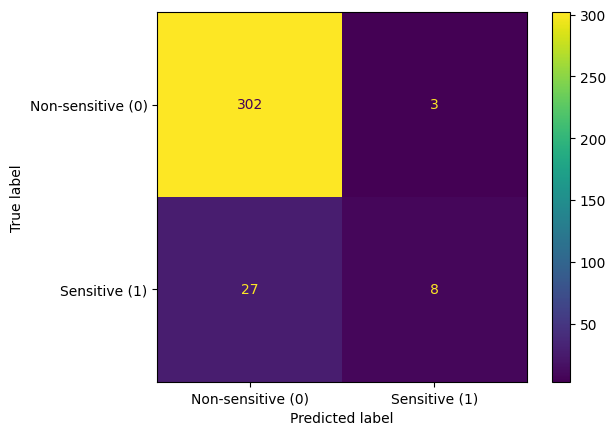

In [17]:
mf_test_preds, rand_test_preds = dummys(training_data, testing_sample)
lr_preds, svm_preds = lr_svm_tdidf(training_data, testing_sample)

In [ ]:
predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(testing_sample, base_prompt_template)
evaluation_summary("Llama-2 Base", scikit_true, scikit_pred)

In [19]:
def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    metrics_data[method] = metric_dict


metrics_data = {}

get_metric_dict('Dummy MF', testing_sample.sensitivity, mf_test_preds)
get_metric_dict('Dummy Rand', testing_sample.sensitivity, rand_test_preds)
get_metric_dict('LR TF-IDF', testing_sample.sensitivity, lr_preds)
get_metric_dict('SVM TF-IDF', testing_sample.sensitivity, svm_preds)
get_metric_dict('Llama-2', scikit_true, scikit_pred)
metrics_data

{'Dummy MF': {'accuracy': 0.8970588235294118,
  'f1_score': 0.8483812129502964,
  'balanced accuracy': 0.5},
 'Dummy Rand': {'accuracy': 0.8117647058823529,
  'f1_score': 0.8140694874441005,
  'balanced accuracy': 0.5030444964871195},
 'LR TF-IDF': {'accuracy': 0.9088235294117647,
  'f1_score': 0.8821306697992257,
  'balanced accuracy': 0.5824355971896955},
 'SVM TF-IDF': {'accuracy': 0.9117647058823529,
  'f1_score': 0.8904168717274318,
  'balanced accuracy': 0.609367681498829},
 'Llama-2': {'accuracy': 0.3573667711598746,
  'f1_score': 0.433458661793497,
  'balanced accuracy': 0.5263581488933602}}

In [20]:
metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index')
metrics_df

,accuracy,f1_score,balanced accuracy
Dummy MF,0.897059,0.848381,0.500000
Dummy Rand,0.811765,0.814069,0.503044
LR TF-IDF,0.908824,0.882131,0.582436
SVM TF-IDF,0.911765,0.890417,0.609368
Llama-2,0.357367,0.433459,0.526358


### Prompts

Prompts used in main experiment below

In [65]:
# Init
def base(document):
  return f"""[INST]
The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information.
Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]

Text: ```{document}```.

Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:'.
Attribute: 
"""

# Using SYS as recommended prompt template does
def base_w_sys(document):
  return f"""<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. The Text is delimited by triple backticks. You must answer after 'Attribute:'.

Text: ```{document}```.

Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:' [/INST].
Attribute: 
"""

def base_w_sys2(document):
  return f"""<s>[INST] 
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
Sensitivity is a measure of sensitive personal information in a business context.
Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
The Text is delimited by triple backticks. You must choose the attribute "sensitive" or "non-sensitive" to classify the Text. The response must start with <ANSWER>, only include the attribute and end with </ANSWER>[/INST]

Text: ```{document}```.

<ANSWER>
"""

#no \n
def base_no_newline(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```{document}```.

Sensitivity:
"""

# YAML
def base_yaml(document):
  return f"""[INST]
The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information.
Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
The Text is delimited by triple backticks. Answer in YAML format, write nothing else, use the following format: ```yaml Attribute: <classification must be attribute "sensitive" or "non-sensitive">```[/INST]

Text: ```{document}```.
"""
"""
```yaml Attribute:
"""

# PE
# Prompts used in script experiment
def pebase(document):
  return f"""Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. 
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Answer:'.
[TEXT]{document}[/TEXT].
Answer:"""

def pepersona(document):
  return f"""Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. From now on, act as an expert sensitivity reviewer. Pay close attention to the personal information details within the document.
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Answer:'.
[TEXT]{document}[/TEXT].
Answer:
"""

def pecot(document):
  return f"""Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. 
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Answer:'. Lets think step by step.
[TEXT]{document}[/TEXT].
Answer:
"""

def base_w_examples(document):
  return f"""<s>[INST] 
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
A document is sensitive if it contains sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Use the format [ANSWER]class[/ANSWER] for your response.

Example:
Text: Document example.
Response: [ANSWER]non-sensitive[/ANSWER]

Text: Another document example.
Response: [ANSWER]sensitive[/ANSWER]

Now classify:
Text: {document}.
Response: [ANSWER]"""


def base_dev(document):
  return f"""<s>[INST] 
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
Sensitivity is a measure of sensitive personal information.
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. The response must follow [ANSWER], include only the attribute, and finish with [/ANSWER].[/INST]
[TEXT]{document}[/TEXT].
[ANSWER]
"""


def base_reordered(document):
  return f"""[INST]
The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information. The Text is delimited by triple backticks.
Text: ```{document}```.
Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
Answer in YAML format, write nothing else, use the following format: ```yaml Attribute: <classification must be attribute "sensitive" or "non-sensitive">```[/INST]
"""


### Main experiment - main call

In [106]:
# Get dataset
# Preprocess
# Get model
# Get prompt
# Run evaluation
# Display evaluation metrics

def main_experiment(portion, portion_value, proc_meth, m, v, prompt_strategy, end_prompt, tokenizer, model):
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    if portion == 'n':
        samp = get_sample_n(sara_df, portion_value)
    else:
        samp = get_sample_frac(sara_df, portion_value)

    #print(samp)

    if proc_meth == 'replies':
        proc_samp = proc3(samp)
    else:
        proc_samp = proc2(samp)
        
    #tokenizer, model = get_model_version(m, v)
    predictions, further_processing_required, model_responses, truths, preds = llm_experiment(proc_samp, prompt_strategy, model, tokenizer, end_prompt)
    new_preds, new_truths = post_process_split_docs(model_responses, further_processing_required, preds)
    #evaluation_summary("Llama-2", truths, preds)
    #get_metric_dict("Llama-2", truths, preds)
    evaluation_summary("Llama-2", new_truths, new_preds)
    get_metric_dict("Llama-2", new_truths, new_preds)
    print(model_responses)
    return model_responses

In [31]:
m = 'get_llama2'
v = "meta-llama/Llama-2-7b-chat-hf"
tokenizer, model = get_model_version(m, v)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


In [75]:
convert = {'base': base,
'base_w_sys': base_w_sys,
'base_w_sys2': base_w_sys2,
'base_no_newline': base_no_newline,
'base_yaml': base_yaml,
'base_w_examples': base_w_examples,
'base_dev': base_dev
}

prompts = ['base', 'base_w_sys', 'base_w_sys2', 'base_no_newline', 'base_yaml', 'base_w_examples', 'base_dev']
ends = ['\nAttribute:', '\nAttribute:', '\n<ANSWER>', '\nSensitivity:', '```.', 'Now classify:', '\n[ANSWER]']


      doc_id                                               text  sensitivity
984   177860  Message-ID: <10548221.1075858884849.JavaMail.e...            1
887    54263  Message-ID: <14136486.1075858478980.JavaMail.e...            1
1272   54629  Message-ID: <13669071.1075863428696.JavaMail.e...            0
108   175555  Message-ID: <18856721.1075847612029.JavaMail.e...            0
1128  173234  Message-ID: <1316288.1075846142442.JavaMail.ev...            0
190   136411  Message-ID: <25832883.1075858708242.JavaMail.e...            0
414   153662  Message-ID: <31809129.1075861939514.JavaMail.e...            0
628   121903  Message-ID: <6084412.1075843432528.JavaMail.ev...            0
1252  173951  Message-ID: <9680351.1075846163806.JavaMail.ev...            0
625   175138  Message-ID: <7180431.1075847577706.JavaMail.ev...            0
746   175707  Message-ID: <4548956.1075847620544.JavaMail.ev...            0
1580  177826  Message-ID: <388049.1075858883718.JavaMail.eva...            0

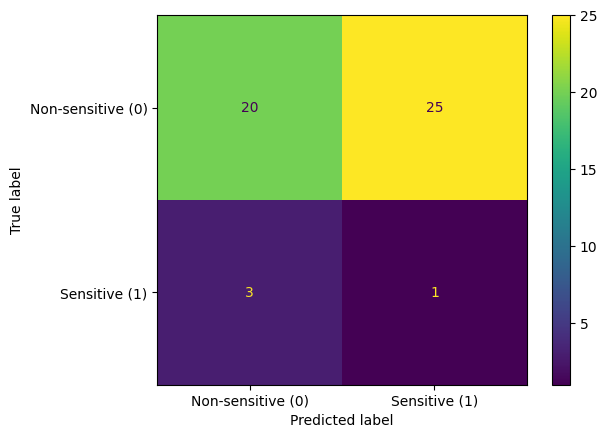

{'accuracy': 0.42857142857142855, 'f1_score': 0.5456582633053222, 'balanced accuracy': 0.3472222222222222}


In [62]:
mr = main_experiment('n', 50, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base, '\nAnswer', tokenizer, model)

In [60]:
mr

{'177860_0': '\nAnswer: Non-sensitive.',
 '177860_1': '\nAnswer: Non-sensitive',
 '54263_0': '\nAnswer: Non-sensitive',
 '54263_1': '\nAnswer: Non-sensitive',
 '54263_2': '\nAnswer: Non-sensitive',
 '54263_3': '\nAnswer: Non-sensitive',
 '54629_0': '\nAnswer: Non-sensitive',
 '54629_1': '\nAnswer: Non-sensitive',
 '175555_0': '\nAnswer: Sensitive',
 '175555_1': '\nAnswer: Non-sensitive',
 '173234': '\nAnswer: Sensitive.\n\nThe text contains personal information such as phone numbers, addresses, and account',
 '136411': '\nAnswer: Sensitive.',
 '153662': '\nAnswer: Sensitive',
 '121903': '\nAnswer: Sensitive.',
 '173951_0': '\nAnswer: Sensitive. \nThe text contains personal information such as names, phone numbers, and sched',
 '173951_1': '\nAnswer: Sensitive.\n\nThe Text contains personal information such as names and contact details of individuals,',
 '175138': '\nAnswer: Confidentiality Notice.',
 '175707_0': '\nAnswer: Sensitive',
 '175707_1': '\nAnswer: Non-sensitive',
 '177826_0'

The following experiments are used for the short report of progress.

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      1.000     0.109     0.196        92
    Sensitive (1)      0.068     1.000     0.128         6

         accuracy                          0.163        98
        macro avg      0.534     0.554     0.162        98
     weighted avg      0.943     0.163     0.192        98



Confusion matrix:


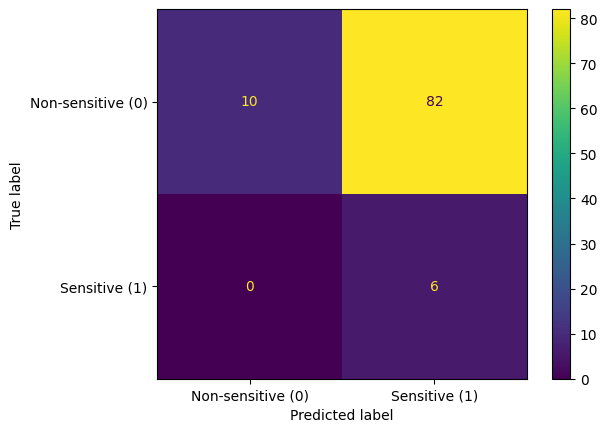

{'accuracy': 0.16326530612244897, 'f1_score': 0.19188952176615326, 'balanced accuracy': 0.5543478260869565}
{'177860_0': '\nAttribute: \nSensitive', '177860_1': '\nAttribute: \nSensitive', '54263_0': '\nAttribute: \nNon-sensitive', '54263_1': '\nAttribute: \nSensitive', '54263_2': '\nAttribute: \nNon-sensitive', '54263_3': '\nAttribute: \nSensitive', '54629_0': '\nAttribute: \nNon-sensitive', '54629_1': '\nAttribute: \nSensitive', '175555_0': '\nAttribute: \nNon-sensitive', '175555_1': '\nAttribute: \nSensitive', '173234': '\nAttribute: \nSensitive', '136411': '\nAttribute: \nNon-sensitive', '153662': '\nAttribute: \nSensitive', '121903': '\nAttribute: \nSensitive', '173951_0': '\nAttribute: \nSensitive', '173951_1': '\nAttribute: \nSensitive', '175138': '\nAttribute: \nSensitive', '175707_0': '\nAttribute: \nSensitive', '175707_1': '\nAttribute: \nSensitive', '177826_0': '\nAttribute: \nSensitive', '177826_1': '\nAttribute: \nSensitive', '150157': '\nAttribute: \nSensitive', '136449':

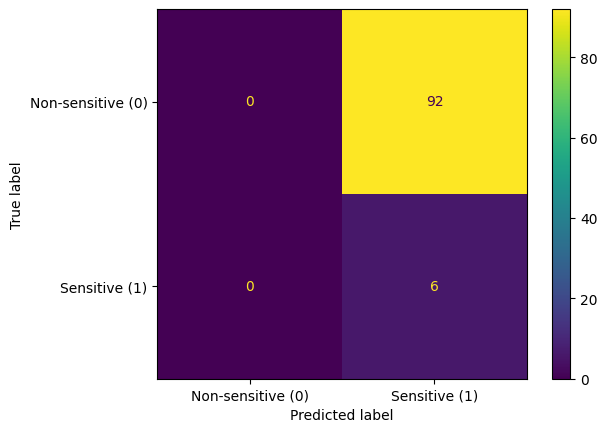

{'accuracy': 0.061224489795918366, 'f1_score': 0.0070643642072213495, 'balanced accuracy': 0.5}
{'177860_0': '\nAttribute: \nSensitive', '177860_1': '\nAttribute: \nSensitive', '54263_0': '\nAttribute: \nSensitive', '54263_1': '\nAttribute: \nSensitive', '54263_2': '\nAttribute: \nSensitive', '54263_3': '\nAttribute: \nSensitive', '54629_0': '\nAttribute: \nSensitive', '54629_1': '\nAttribute: \nSensitive', '175555_0': "\nAttribute: \n\nI'm just an AI, I don't have access to any personal information or", '175555_1': '\nAttribute: \nSensitive', '173234': '\nAttribute: \nSensitive', '136411': '\nAttribute: \nSensitive', '153662': '\nAttribute: \nSensitive', '121903': '\nAttribute: \nSensitive', '173951_0': '\nAttribute: \nSensitive', '173951_1': '\nAttribute: \nSensitive', '175138': '\nAttribute: \nSensitive', '175707_0': '\nAttribute: \nSensitive', '175707_1': '\nAttribute: \nSensitive', '177826_0': '\nAttribute: \nSensitive', '177826_1': '\nAttribute: \nNon-sensitive', '150157': '\nAtt

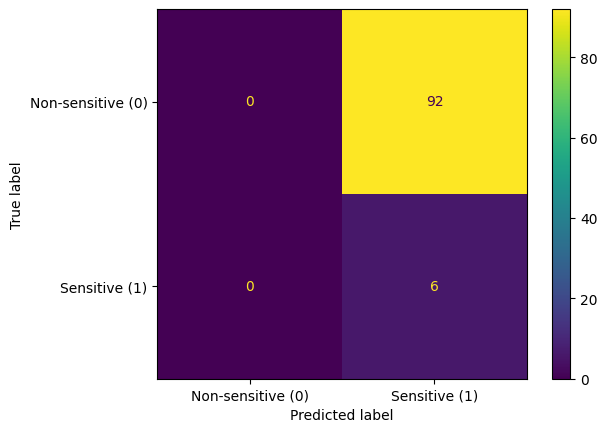

{'accuracy': 0.061224489795918366, 'f1_score': 0.0070643642072213495, 'balanced accuracy': 0.5}
{'177860_0': '\n<ANSWER>\nSensitive</ANSWER>\n\nExplanation: The Text contains personal information (', '177860_1': '\n<ANSWER>\nSensitive\n</ANSWER>', '54263_0': '\n<ANSWER>\nSensitive\n</ANSWER>', '54263_1': '\n<ANSWER>\nSensitive\n</ANSWER>', '54263_2': '\n<ANSWER>\nSensitive\n</ANSWER>', '54263_3': '\n<ANSWER>\nSensitive\n</ANSWER>', '54629_0': '\n<ANSWER>\nSensitive\n</ANSWER>', '54629_1': '\n<ANSWER>\nSensitive\n</ANSWER>', '175555_0': '\n<ANSWER>\nSensitive\n</ANSWER>', '175555_1': '\n<ANSWER>\nSensitive\n</ANSWER>', '173234': '\n<ANSWER>\nSensitive\n</ANSWER>', '136411': '\n<ANSWER>\nSensitive</ANSWER>', '153662': '\n<ANSWER>\nSensitive</ANSWER>', '121903': '\n<ANSWER>\nSensitive</ANSWER>', '173951_0': '\n<ANSWER>\nSensitive\n</ANSWER>', '173951_1': '\n<ANSWER>\nSensitive\n</ANSWER>', '175138': '\n<ANSWER>\nSensitive\n</ANSWER>', '175707_0': '\n<ANSWER>\nSensitive\n</ANSWER>', '17570

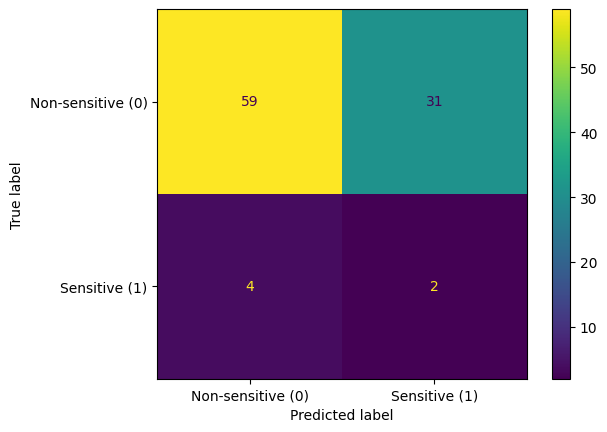

{'accuracy': 0.6354166666666666, 'f1_score': 0.7294494720965309, 'balanced accuracy': 0.49444444444444446}
{'177860_0': '\nSensitivity:\n\n* Sensitive: none\n* Non-sensitive: call', '177860_1': '\nSensitivity:\nNon-sensitive', '54263_0': '\nSensitivity:\n\nThe attribute that classifies the Text as "sensitive" is:\n\n* Personal information', '54263_1': '\nSensitivity:\n\nThe attribute that classifies the Text as "sensitive" is:\n\n* "Europe', '54263_2': '\nSensitivity:\n\nThe attribute that classifies the Text as "sensitive" is:\n\nNon-sens', '54263_3': '\nSensitivity:\nNon-sensitive', '54629_0': '\nSensitivity:\n\nThe attribute that classifies the Text as "sensitive" is:\n\nNon-sens', '54629_1': '\nSensitivity:\nNon-sensitive', '175555_0': '\nSensitivity:\n\n* Sensitive: `non-sensitive`\n\nTherefore, the attribute that', '175555_1': '\nSensitivity:\n\n* Non-sensitive', '173234': '\nSensitivity:\n\nThe attribute that classifies the Text as "sensitive" is:\n\n* "P', '136411': '\nSensitiv

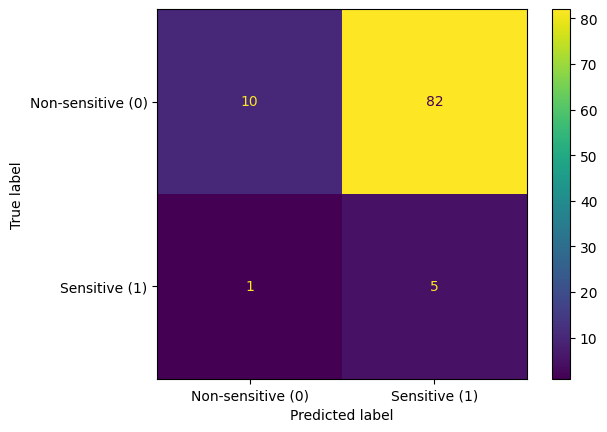

{'accuracy': 0.15306122448979592, 'f1_score': 0.1888697853084234, 'balanced accuracy': 0.4710144927536232}
{'177860_0': '```.\n\nAttribute: sensitive', '177860_1': '```.\n\nAttribute: sensitive', '54263_0': '```.\n\nAttribute: sensitive', '54263_1': '```.\n\nAttribute: sensitive', '54263_2': '```.\n\nAttribute: non-sensitive', '54263_3': '```.\n\nAttribute: sensitive', '54629_0': '```.\n\nAttribute: non-sensitive', '54629_1': '```.\n\nAttribute: sensitive', '175555_0': '```.\n\nAttribute: sensitive', '175555_1': '```.\n\nAttribute: sensitive', '173234': '```.\n\nAttribute: sensitive', '136411': '```.\n\nAttribute: sensitive\n\nExplanation: The Text contains sensitive personal information, such as the', '153662': '```.\n\nAttribute: sensitive', '121903': '```.\n\nAttribute: sensitive', '173951_0': '```.\n\nAttribute: non-sensitive', '173951_1': '```.\n\nAttribute: sensitive', '175138': '```.\n\nAttribute: sensitive', '175707_0': '```.\n\nAttribute: sensitive', '175707_1': '```.\n\nAttri

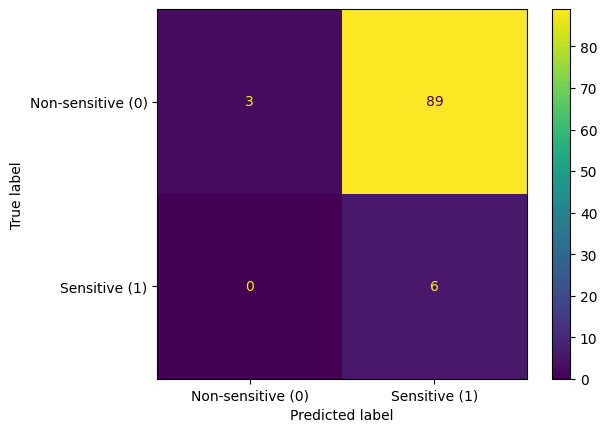

{'accuracy': 0.09183673469387756, 'f1_score': 0.06656528166243048, 'balanced accuracy': 0.5163043478260869}
{'177860_0': 'Now classify:\nText: Call at 5:00 today (3:00 your time), if you can. .\nResponse: [ANSWER]sensitive[/ANSWER]', '177860_1': "Now classify:\nText: Subject: Moving foward at a good clip Steve Good news. As you indicated would happen, Kalen Pieper called me mid-week. We had a very good conversation about EES and Dave Delainey's leadership. She explored my views about doing business with government. Shortly thereafter, Dave's office called to invite me to Houston on Thursday July 26. Kay Chapman explained that Dave's schedule would keep him out of pocket until August 16. In order to move forward, Janet Dietrich will be meeting with me when I go to Houston next Thursday. (I must confess that after all the great things I have heard about the man, I do look forward to meeting Dave himself.) Is there a time next week that I can speak with you by phone to fine-tune my thinki

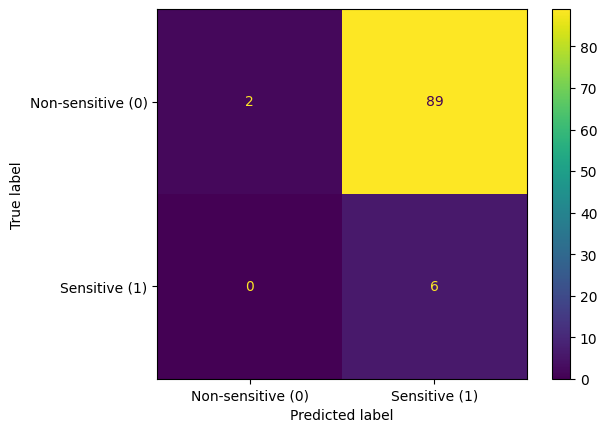

{'accuracy': 0.08247422680412371, 'f1_score': 0.0476994822861069, 'balanced accuracy': 0.510989010989011}
{'177860_0': '[ANSWER], include only the attribute, and finish with [/ANSWER].[/INST]\n[TEXT]Call at 5:00 today (3:00 your time), if you can. [/TEXT].\n[ANSWER]\nThe attribute that classifies the Text as "sensitive" is "personal information".', '177860_1': '[ANSWER], include only the attribute, and finish with [/ANSWER].[/INST]\n[TEXT]Subject: Moving foward at a good clip Steve Good news. As you indicated would happen, Kalen Pieper called me mid-week. We had a very good conversation about EES and Dave Delainey\'s leadership. She explored my views about doing business with government. Shortly thereafter, Dave\'s office called to invite me to Houston on Thursday July 26. Kay Chapman explained that Dave\'s schedule would keep him out of pocket until August 16. In order to move forward, Janet Dietrich will be meeting with me when I go to Houston next Thursday. (I must confess that afte

In [81]:
for i, p in enumerate(prompts):
    mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", convert.get(p), ends[i], tokenizer, model)


Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.942     0.285     0.438       172
    Sensitive (1)      0.075     0.769     0.137        13

         accuracy                          0.319       185
        macro avg      0.509     0.527     0.287       185
     weighted avg      0.881     0.319     0.416       185



Confusion matrix:


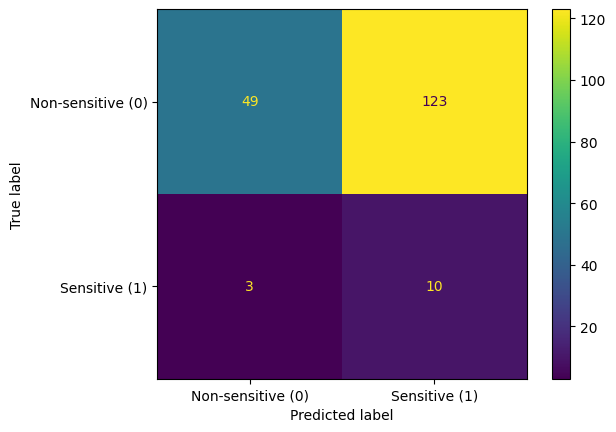

{'accuracy': 0.31891891891891894, 'f1_score': 0.41638282117734177, 'balanced accuracy': 0.5270572450805009}
{'177860_0': '\nAttribute: \nSensitive', '177860_1': '\nAttribute: \nSensitive', '54263_0': '\nAttribute: \nNon-sensitive', '54263_1': '\nAttribute: \nSensitive', '54263_2': '\nAttribute: \nNon-sensitive', '54263_3': '\nAttribute: \nSensitive', '54629_0': '\nAttribute: \nNon-sensitive', '54629_1': '\nAttribute: \nSensitive', '175555_0': '\nAttribute: \nNon-sensitive', '175555_1': '\nAttribute: \nSensitive', '173234': '\nAttribute: \nSensitive', '136411': '\nAttribute: \nNon-sensitive', '153662': '\nAttribute: \nSensitive', '121903': '\nAttribute: \nSensitive', '173951_0': '\nAttribute: \nSensitive', '173951_1': '\nAttribute: \nSensitive', '175138': '\nAttribute: \nSensitive', '175707_0': '\nAttribute: \nSensitive', '175707_1': '\nAttribute: \nSensitive', '177826_0': '\nAttribute: \nSensitive', '177826_1': '\nAttribute: \nSensitive', '150157': '\nAttribute: \nSensitive', '136449':

{'177860_0': '\nAttribute: \nSensitive',
 '177860_1': '\nAttribute: \nSensitive',
 '54263_0': '\nAttribute: \nNon-sensitive',
 '54263_1': '\nAttribute: \nSensitive',
 '54263_2': '\nAttribute: \nNon-sensitive',
 '54263_3': '\nAttribute: \nSensitive',
 '54629_0': '\nAttribute: \nNon-sensitive',
 '54629_1': '\nAttribute: \nSensitive',
 '175555_0': '\nAttribute: \nNon-sensitive',
 '175555_1': '\nAttribute: \nSensitive',
 '173234': '\nAttribute: \nSensitive',
 '136411': '\nAttribute: \nNon-sensitive',
 '153662': '\nAttribute: \nSensitive',
 '121903': '\nAttribute: \nSensitive',
 '173951_0': '\nAttribute: \nSensitive',
 '173951_1': '\nAttribute: \nSensitive',
 '175138': '\nAttribute: \nSensitive',
 '175707_0': '\nAttribute: \nSensitive',
 '175707_1': '\nAttribute: \nSensitive',
 '177826_0': '\nAttribute: \nSensitive',
 '177826_1': '\nAttribute: \nSensitive',
 '150157': '\nAttribute: \nSensitive',
 '136449': '\nAttribute: \nSensitive',
 '175201_0': '\nAttribute: \nNon-sensitive',
 '175201_1':

In [94]:
mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base, '\nAttribute:', tokenizer, model)
mr


#### Further testing with prompt that does not follow the near consistent 'sensitive' prediction.

Different answer initiations.

In [96]:
# Most non-sens right
def base_interest(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```{document}```.

Attribute:
"""

def base_interest2(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```{document}```.

Answer:
"""

def base_interest3(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```{document}```.

Attribute:"""

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.927     0.413     0.571        92
    Sensitive (1)      0.053     0.500     0.095         6

         accuracy                          0.418        98
        macro avg      0.490     0.457     0.333        98
     weighted avg      0.873     0.418     0.542        98



Confusion matrix:


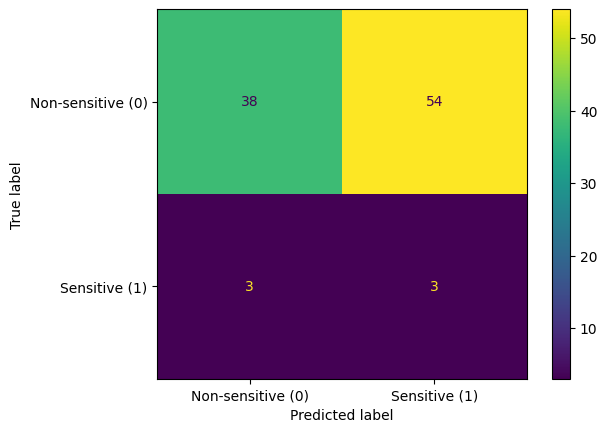

{'accuracy': 0.41836734693877553, 'f1_score': 0.5422740524781341, 'balanced accuracy': 0.4565217391304348}
{'177860_0': '\nAttribute:\nSensitive: Non-sensitive', '177860_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '54263_0': '\nAttribute:\nSensitive', '54263_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '54263_2': '\nAttribute:\n\n* Sensitive: Non-sensitive', '54263_3': '\nAttribute:\n\n* Sensitive: Non-sensitive', '54629_0': '\nAttribute:\nSensitive: Non-sensitive', '54629_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '175555_0': '\nAttribute:\n\nSensitive:', '175555_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '173234': '\nAttribute:\n\nSensitive:\n\nThe Text contains sensitive information, specifically the phone number (94', '136411': '\nAttribute:\n\n* Sensitive: Non', '153662': '\nAttribute:\n\n* Sensitive: Yes', '121903': '\nAttribute:\n\n* Sensitive: Non-sensitive', '173951_0': '\nAttribute:\n\n* sensitive: Non-sensitive', '173951_1': '\nAttribute:\n\n* Sensit

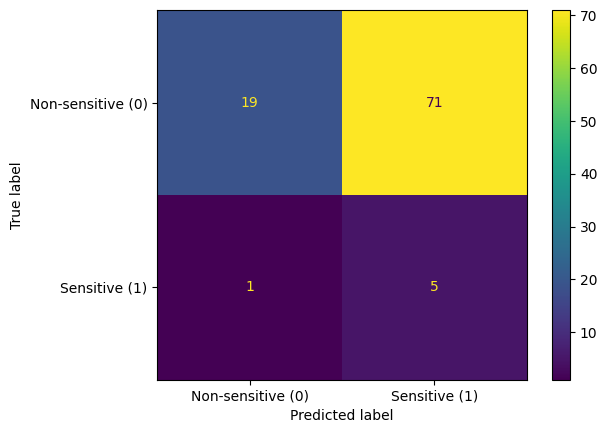

{'accuracy': 0.25, 'f1_score': 0.33148558758314856, 'balanced accuracy': 0.5222222222222223}
{'177860_0': '\nAnswer:\n\nAttribute: sensitive', '177860_1': '\nAnswer:\n\nAttribute: Non-sensitive', '54263_0': '\nAnswer:\n\nAttribute: sensitive', '54263_1': '\nAnswer:\n\nAttribute: Non-sensitive', '54263_2': '\nAnswer:\n\nAttribute: Non-sensitive', '54263_3': '\nAnswer:\n\nThe attribute that classifies the Text as "sensitive" is:\n\n* "Conf', '54629_0': '\nAnswer:\n\nAttribute: sensitive', '54629_1': '\nAnswer:\n\nThe attribute that classifies the Text as "sensitive" or "non-sensitive"', '175555_0': '\nAnswer:\n\nAttribute: sensitive', '175555_1': '\nAnswer:\n\nAttribute: Sensitive', '173234': '\nAnswer:\n\nAttribute: Sensitive', '136411': '\nAnswer:\n\nAttribute: "sensitive"', '153662': '\nAnswer:\n\nSensitive: Yes', '121903': '\nAnswer:\n\nThe attribute that classifies the Text as "sensitive" or "non-sensitive"', '173951_0': '\nAnswer:\n\nThe attribute "sensitive" classifies the Text as

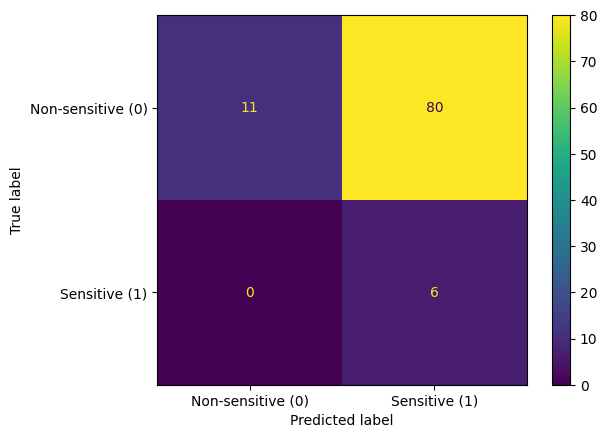

{'accuracy': 0.17525773195876287, 'f1_score': 0.21041298635097253, 'balanced accuracy': 0.5604395604395604}
{'177860_0': '\nAttribute: sensitive', '177860_1': '\nAttribute: "sensitive"\n\nThe text is sensitive as it contains personal information such as contact details (', '54263_0': '\nAttribute: sensitive', '54263_1': '\nAttribute: sensitive\n\nAnswer: The attribute "sensitive" classifies the Text as non-sensitive', '54263_2': '\nAttribute: sensitive', '54263_3': '\nAttribute: "sensitive"', '54629_0': '\nAttribute: sensitive\n\nClassification: non-sensitive', '54629_1': '\nAttribute: "sensitive"', '175555_0': '\nAttribute: sensitive', '175555_1': '\nAttribute: Sensitive', '173234': '\nAttribute: sensitive\n\nAnswer: The attribute "sensitive" classifies the Text as non-sensitive', '136411': '\nAttribute: "sensitive" or "non-sensitive"\n\nAnswer: The attribute "sensitive', '153662': '\nAttribute: "sensitive"', '121903': '\nAttribute: "sensitive"', '173951_0': '\nAttribute: sensitive', 

In [97]:
mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base_interest, '\nAttribute:', tokenizer, model)
mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base_interest2, '\nAnswer:', tokenizer, model)
mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base_interest3, '\nAttribute:', tokenizer, model)



Including 'the text is sensitive' explanation.

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      1.000     0.120     0.214        92
    Sensitive (1)      0.069     1.000     0.129         6

         accuracy                          0.173        98
        macro avg      0.534     0.560     0.171        98
     weighted avg      0.943     0.173     0.208        98



Confusion matrix:


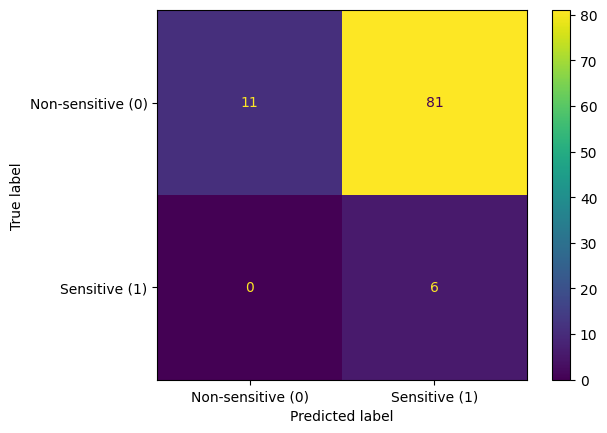

{'accuracy': 0.17346938775510204, 'f1_score': 0.20841509168653366, 'balanced accuracy': 0.5597826086956522}
{'177860_0': '\nAttribute:\nSensitive: No', '177860_1': '\nAttribute:\n\n* Sensitive: Non', '54263_0': '\nAttribute:\nSensitive\n\nExplanation: The Text contains personal information (name and institution) of', '54263_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '54263_2': '\nAttribute:\nSensitive: Non-sensitive', '54263_3': '\nAttribute:\n\n* Sensitive: Non', '54629_0': '\nAttribute:\nSensitive\n```', '54629_1': '\nAttribute:\n\n* Sensitive: Non', '175555_0': '\nAttribute:\n\n* Sensitive: No', '175555_1': '\nAttribute:\n\n* Sensitive: Non', '173234': '\nAttribute:\n\nSensitive:\n\nNon-sensitive:', '136411': '\nAttribute:\n\n* Sensitive: [Non-sensitive]', '153662': '\nAttribute:\n\n* Sensitive: Yes', '121903': '\nAttribute:\n\n* Sensitive: 🚫', '173951_0': '\nAttribute:\n\n* Sensitive: Non', '173951_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '175138': '\nAttribute:\nSe

In [98]:
def base_interest(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. The Text is sensitive if it contains sensitive personal information. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```{document}```.

Attribute:
"""
mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base_interest, '\nAttribute:', tokenizer, model)


* Providing obvious sentences to the model (both correct) as expected.
* Using 'text is non-sensitive' if explanation tag, which flips model responses.

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.928     0.837     0.880        92
    Sensitive (1)      0.000     0.000     0.000         6

         accuracy                          0.786        98
        macro avg      0.464     0.418     0.440        98
     weighted avg      0.871     0.786     0.826        98



Confusion matrix:


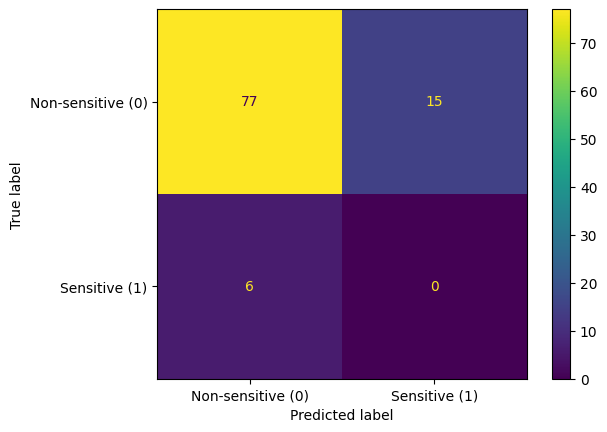

{'accuracy': 0.7857142857142857, 'f1_score': 0.826122448979592, 'balanced accuracy': 0.41847826086956524}
{'177860_0': '\nAttribute:\nNon-sensitive', '177860_1': '\nAttribute:\nNon-sensitive', '54263_0': '\nAttribute:\nNon-sensitive', '54263_1': '\nAttribute:\nNon-sensitive', '54263_2': '\nAttribute:\nNon-sensitive', '54263_3': '\nAttribute:\n\n* Sensitive: Non-sensitive', '54629_0': '\nAttribute:\nNon-sensitive', '54629_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '175555_0': '\nAttribute:\n\nSensitive: Non-sensitive', '175555_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '173234': '\nAttribute:\n\nSensitive:\n\nNon-sensitive:', '136411': '\nAttribute:\n\n* Sensitive: Non', '153662': '\nAttribute:\n\n* Sensitive: Non-sensitive', '121903': '\nAttribute:\n\n* Sensitive: Non', '173951_0': '\nAttribute:\n\n* Sensitive: Non-sensitive', '173951_1': '\nAttribute:\n\n* Sensitive: Non-sensitive', '175138': '\nAttribute:\n\n* Sensitive: No', '175707_0': '\nAttribute:\n\nSensitive: Non-

In [108]:
def base_interest3(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```James went through a divorce and can only see his kids on Friday, so will not be available for the meeting.```.

Attribute:"""

def base_interest3(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```How about we call on Friday at 4 o'clock.```.

Attribute:"""

def base_interest(document):
  return f"""<s>[INST]
<<SYS>> You are a helpful AI assistant. Always answer as helpfully as possible.<</SYS>>
The Text is delimited by triple backticks. The Text is from an email. The Text is non-sensitive if it does not contain sensitive personal information. Which attribute “sensitive”, “non-sensitive” classifies the Text. The response must only include the attribute.[/INST]

Text: ```{document}```.

Attribute:
"""


mr = main_experiment('n', 100, 'replies', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", base_interest, '\nAttribute:', tokenizer, model)


### Mistral

GPT-2 has been less useful than L2 so far. Mistral promises excellent performance, over L2 for some tasks. This attempts to evaluate this model.

In [8]:
#!pip install jinja2
#!pip install -U transformers

In [9]:
def first_use_mistral():
    messages = [
        {"role": "user", "content": "What is your favourite condiment?"}
    ]
    messages = [
        {"role": "user", "content": "What is your favourite condiment?"},
        {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
        {"role": "user", "content": "Do you have mayonnaise recipes?"}
    ]
    messages = [
        {"role": "user", "content": "What does sensitive personal information mean?"}
    ]

    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
    #encodeds = tokenizer("What does sensitive personal information mean?", return_tensors='pt')
    model_inputs = encodeds.to(device)
    print(model_inputs)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    generated_ids = model.generate(model_inputs, max_new_tokens=200, do_sample=True)
    #print(generated_ids)
    decoded = tokenizer.batch_decode(generated_ids)
    print(decoded[0])


device = "cuda"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", cache_dir=my_cache)


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


In [10]:
model_inputs = first_use_mistral()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


tensor([[    1,   733, 16289, 28793,  1824,  1235, 13509,  3327,  1871,  2072,
         28804,   733, 28748, 16289, 28793]], device='cuda:0')
<s> [INST] What does sensitive personal information mean? [/INST] Sensitive personal information refers to data that reveals sensitive or confidential details about an individual. This type of information is considered private and is deserving of special protection because its disclosure could result in harm to the individual if it falls into the wrong hands. Examples of sensitive personal information include:

1. Social security numbers, national insurance numbers or other government identification numbers.
2. Bank account numbers and other financial information.
3. Medical records and health information.
4. Details about racial or ethnic origin, religious beliefs or sexual orientation.
5. Criminal records or other information related to past legal issues.
6. Home addresses, phone numbers, and other contact information.
7. Biometric data such as

In [11]:
def mistral_without_chat_template():
    inputs = tokenizer("<s> [INST] What does sensitive personal information mean? [/INST]", return_tensors='pt')
    generation_config = GenerationConfig(
        max_new_tokens=200
    )
    inp = inputs.input_ids.to('cuda')
    att = inputs.attention_mask.to('cuda')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    output = model.generate(inputs=inp, attention_mask=att, max_new_tokens=150, do_sample=False)
    y = tokenizer.decode(output[0], skip_special_tokens=True)
    print(y)


mistral_without_chat_template()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 [INST] What does sensitive personal information mean? [/INST] Sensitive personal information refers to data that is considered private and could potentially be used to harm an individual's privacy or security if it is disclosed without consent. This type of information often includes details such as:

1. Financial information: This includes bank account numbers, credit card numbers, and other financial data that can be used for identity theft or financial fraud.
2. Personal identification information: This includes social security numbers, driver's license numbers, and other government-issued identification numbers that can be used to verify an individual's identity.
3. Health information: This includes medical records, mental and physical health conditions, and other sensitive health information that is protected by law.
4. Legal information: This includes


SARA and Mistral

In [19]:
samp = sara_df.sample(frac=0.1, random_state=8)
#samp = sara_df.sample(n=5, random_state=8)

samp = get_preprocessed_sara(samp)
samp.head()

,doc_id,text,sensitivity
0,175555_0,---------------------- Forwarded by Steven J K...,0
1,175555_1,Subject: EES Talking ABout Sending Back the Ne...,0
2,175555_2,"EES is considering ""re-sourcing"" the new custo...",0
3,175555_3,Sue Mara\nEnron Corp.\nTel: (415) 782-7802\nFa...,0
4,177838_0,Subject:\tMeeting Notice - California Document...,0


Using the chat template (must modify llm_inference)

In [20]:
def llm_inference(document, prompt, model):
  messages = [
    {"role": "user", "content": get_prompt_template(document, prompt)}
  ]
  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
  inputs = encodeds.to('cuda')
  ### Array like
  arr_like = torch.ones_like(inputs)
  attention_mask = arr_like.to('cuda')
  generated_ids = model.generate(inputs=inputs, attention_mask=attention_mask, max_new_tokens=150, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)
  return decoded[0]

In [21]:
def base_prompt_template(document):
  return f"""<s> [INST]
  The Text is sensitive if it contains sensitive personal information.
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'
  
  Text: ```{document}```.

  Attribute:[/INST]
  """

In [24]:
def test_format(document):
  return f"""[INST]
The Text is sensitive if it contains sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. The Text is delimited by triple backticks. You must answer after 'Attribute:'.[/INST]
Text: ```Last week David from the fifth floor went through with the divorce. We also have to skip this meeting as he cannot attend.```.
"""

def display_gen_text(output):
  end_template = output.find('```.')
  return output[end_template:]


In [25]:
samp = sara_df.sample(n=1, random_state=8)
_, fpr, mr, t, p = llm_experiment(samp, test_format)
print(mr)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'175555': '```.\n [/INST] Attribute: non-sensitive. The text does not contain any sensitive personal information as defined by data protection laws.</s>'}


As Mistral seemed to strongly recommend use of '[INST]' tags, we try using [TEXT] as delimiters.

In [31]:
def dev1(document):
  return f"""<s>[INST] 
Sensitivity is a measure of sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. The Text is delimited by triple backticks. You must choose the attribute "sensitive" or "non-sensitive" to classify the Text. The response must only include the attribute.
Text: ```{document}```.
Attribute:[/INST]
"""

def dev2(document):
  return f"""[INST]
Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. The Text is delimited by [TEXT]. You must answer after 'Attribute:'.[/INST]
[TEXT]{document}[/TEXT].
[INST]Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Attribute:'.[/INST]
Attribute:
"""

def display_gen_text(output):
  end_template = output.find('\nAttribute:')
  return output[end_template:]


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


DEV1 Method


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.512     0.911     0.656        45
    Sensitive (1)      0.000     0.000     0.000        39

         accuracy                          0.488        84
        macro avg      0.256     0.456     0.328        84
     weighted avg      0.275     0.488     0.351        84



Confusion matrix:


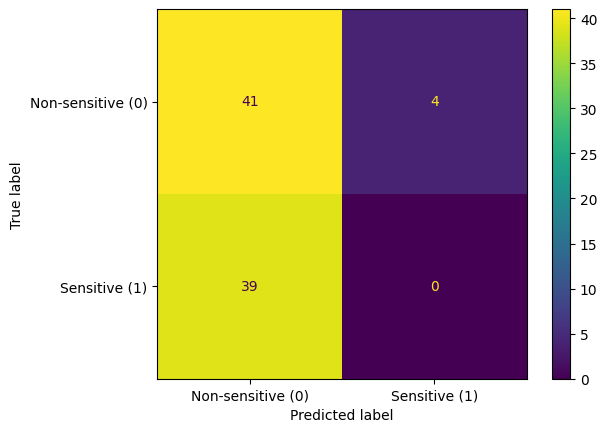

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'175555_0': '\nAttribute:[/INST]\n [/INST] non-sensitive. \n\nThis text appears to only contain metadata and does not contain any sensitive personal information.</s>', '175555_1': '\nAttribute:[/INST]\n [/INST] non-sensitive.\n\nThe text does not contain any sensitive information. The subject line appears to be related to a business or organization communication regarding a potential change in customers.</s>', '175555_2': "\nAttribute:[/INST]\n [/INST] non-sensitive.\n\nThe text seems to be discussing business strategies and potential implications for a company's reputation in the market. There's no indication of any personal or sensitive information being shared.</s>", '175555_3': '\nAttribute:[/INST]\n [/INST] sensitive</s>', '177838_0': '\nAttribute:[/INST]\n [/INST] non-sensitive.</s>', '177838_1': '\nAttribute:[/INST]\n [/INST] non-sensitive.</s>', '177838_2': '\nAttribute:[/INST]\n [/INST] sensitivity: sensitive</s>', '174374_0': '\nAttribute:[/INST]\n [/INST] non-sensitive</s>'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.500     0.844     0.628        45
    Sensitive (1)      0.000     0.000     0.000        38

         accuracy                          0.458        83
        macro avg      0.250     0.422     0.314        83
     weighted avg      0.271     0.458     0.341        83



Confusion matrix:


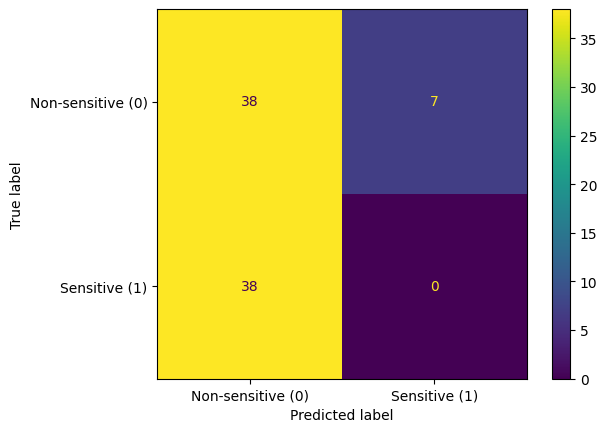

{'175555_0': "\nAttribute:\n [/INST] sensitive. The text appears to have been forwarded from a professional email account, but it includes no context or information to definitively label it as non-sensitive. Given the lack of context, it's more prudent to assume the text may contain sensitive information, especially considering that emails from professional accounts like those used at Enron were subject to various data protection policies and regulations.</s>", '175555_1': '\nAttribute:\n [/INST] non-sensitive. The text appears to be discussing business matters related to SDG&E customers, and there is no indication of the sharing of sensitive personal information.</s>', '175555_2': '\nAttribute:\n [/INST] This text does not contain sensitive information related to personal data. It is about a business matter related to Enron and CA Procurement Charge in a professional context. Therefore, I would classify it as non-sensitive.</s>', '175555_3': '\nAttribute:\n [/INST] sensitive.\n\nThis 

In [32]:
samp = sara_df.sample(n=10, random_state=8)
samp = get_preprocessed_sara(samp)
print('DEV1 Method')
_, fpr, mr, t, p = llm_experiment(samp, dev1)
evaluation_summary("Mistral", t, p)
print(mr)
get_metric_dict('Mistral', t, p)

print('DEV2 Method')
_, fpr, mr, t, p = llm_experiment(samp, dev2)
evaluation_summary("Mistral", t, p)
print(mr)
get_metric_dict('Mistral', t, p)

Dev4: realisation that the chat template applies [INST] to the text.

In [33]:
def display_gen_text(output):
  end_template = output.find('\nAnswer:')
  return output[end_template:]

def dev3(document):
  return f"""[INST]
Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. 
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Answer:'.
[/INST]
[TEXT]{document}[/TEXT].
Answer:
"""

def dev4(document):
  return f"""Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. 
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Answer:'.
[TEXT]{document}[/TEXT].
Answer:
"""


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


DEV3 Method


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.530     0.978     0.688        45
    Sensitive (1)      0.000     0.000     0.000        39

         accuracy                          0.524        84
        macro avg      0.265     0.489     0.344        84
     weighted avg      0.284     0.524     0.368        84



Confusion matrix:


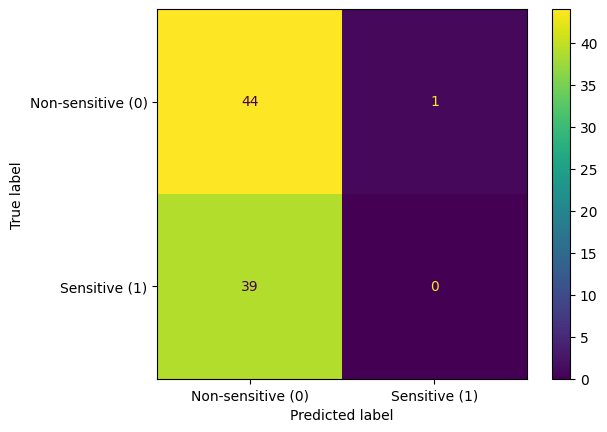

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'175555_0': '\nAnswer:\n [/INST] non-sensitive.\n\nThis text appears to be a forwarded email in plain text format with no personal identification or sensitive information revealed.</s>', '175555_1': '\nAnswer:\n [/INST] non-sensitive.\n\nThis text does not contain any explicit mention or indication of sensitive personal information like financial details, social security numbers, medical information, etc. Therefore, it falls under the category of non-sensitive information.</s>', '175555_2': '\nAnswer:\n [/INST] non-sensitive.\n\nThe text appears to discuss business strategies and Market dynamics without revealing any sensitive personal information.</s>', '175555_3': '\nAnswer:\n [/INST] non-sensitive.\n\nThe provided text contains contact information that is generally considered non-sensitive.</s>', '177838_0': '\nAnswer:\n [/INST] non-sensitive.\n\nThe text appears to discuss a business matter related to document production issues in California, which does not indicate any sensitive 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.564     0.978     0.715        45
    Sensitive (1)      0.800     0.105     0.186        38

         accuracy                          0.578        83
        macro avg      0.682     0.542     0.451        83
     weighted avg      0.672     0.578     0.473        83



Confusion matrix:


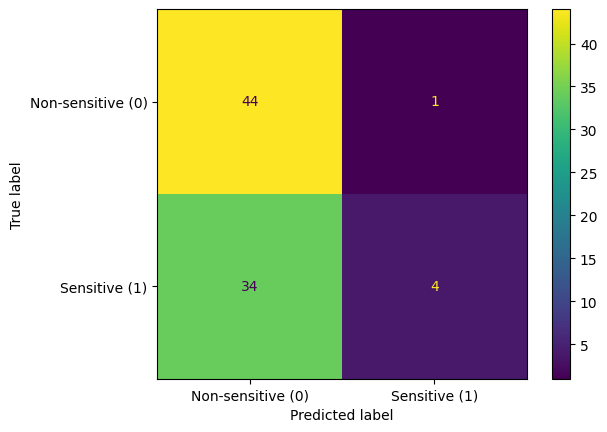

{'175555_0': '\nAnswer:\n [/INST] non-sensitive.\n\nThe text itself does not contain any sensitive personal information. It is simply a forwarded email message with a date and time stamp.</s>', '175555_1': '\nAnswer:\n [/INST] non-sensitive.\n\n[TEXT] does not appear to contain any sensitive personal information, as it only mentions sending back new customers for a utility company.</s>', '175555_2': "\nAnswer:\n [/INST] sensitive\n\nExplanation:\nThe text contains information related to Enron's business strategies and potential actions, as well as their impact on Enron's reputation in the DA market. This information could be considered sensitive as it could potentially impact Enron's competitive position and reputation in the industry.</s>", '175555_3': '\nAnswer:\n [/INST] non-sensitive.\n\nThe text contains only contact information for a person named Sue Mara who works at Enron Corp., which is not considered sensitive personal information.</s>', '177838_0': '\nAnswer:\n [/INST] non-s

In [34]:
print('DEV3 Method')
_, fpr, mr, t, p = llm_experiment(samp, dev3)
evaluation_summary("Mistral", t, p)
print(mr)
get_metric_dict('Mistral', t, p)

print('DEV4 Method')
_, fpr, mr, t, p = llm_experiment(samp, dev4)
evaluation_summary("Mistral", t, p)
print(mr)
get_metric_dict('Mistral', t, p)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.887     0.930     0.908       823
    Sensitive (1)      0.134     0.085     0.104       106

         accuracy                          0.833       929
        macro avg      0.511     0.507     0.506       929
     weighted avg      0.802     0.833     0.816       929



Confusion matrix:


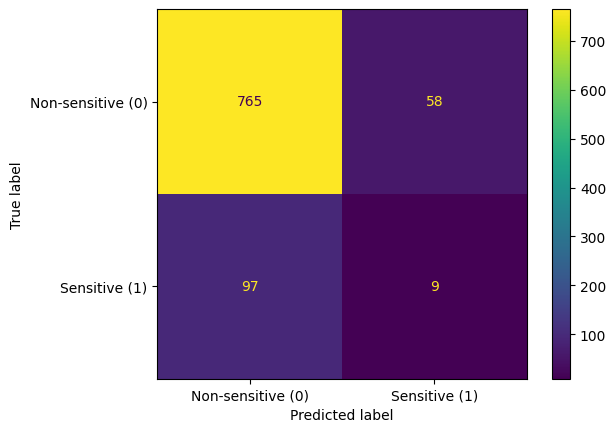

{'accuracy': 0.8331539289558665, 'f1_score': 0.816278439483421, 'balanced accuracy': 0.5072158921570875}


In [35]:
samp = sara_df.sample(frac=0.1, random_state=8)
samp = get_preprocessed_sara(samp)
_, fpr, mr, t, p = llm_experiment(samp, dev4)
evaluation_summary("Mistral", t, p)
get_metric_dict('Mistral', t, p)

In [36]:
mr

{'175555_0': '\nAnswer:\n [/INST] non-sensitive.\n\nThe text does not contain any clear indications of sensitive personal information. If the text contained sensitive information, it would typically be identified as such in the message or its context.</s>',
 '175555_1': '\nAnswer:\n [/INST] non-sensitive.\n\nReason:\nThe text subject does not contain clear indications of sensitive personal information, such as credit card numbers, social security numbers, health information, or personal correspondence that would require special protection or privacy concerns in a professional context.</s>',
 '175555_2': '\nAnswer:\n [/INST] sensitive.\n\nExplanation:\nThe text mentions Enron, a company that was involved in high-profile accounting scandals in the early 2000s. This information, while related to a professional context, could be considered sensitive due to its potential to impact public perception and reputation.</s>',
 '175555_3': "\nAnswer:\n [/INST] non-sensitive.\n\nThe provided text c

Using no chat template, following the same function as Llama-2. Moving tensors to cuda in generate (as we have done before) does not work, so do this prior.

In [47]:
samp = sara_df.sample(frac=0.1, random_state=8)
samp = get_preprocessed_sara(samp)

In [48]:
def odev(document):
  return f"""<s> [INST] Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. 
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. Only respond with the attribute after 'Answer:'.
[TEXT]{document}[/TEXT].
Answer: [/INST]
"""

def dev(document):
  return f"""<s> [INST] Sensitivity is a measure of sensitive personal information in a purely personal and personal in a professional context. 
The Text is delimited by [TEXT]. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. [/INST]
[TEXT]{document}[/TEXT].
[INST] Only respond with the attribute after 'Answer:'. [/INST]
Answer:
"""

def llm_inference(document, prompt, model):
  inputs = tokenizer(get_prompt_template(document, prompt), return_tensors='pt')
  generation_config = GenerationConfig(
    # Unable to set temperature to 0 - https://github.com/facebookresearch/llama/issues/687 - use do_sample=False for greedy decoding
    do_sample=False,
    max_new_tokens=20,
  )
  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

  inp = inputs.input_ids.to('cuda')
  att = inputs.attention_mask.to('cuda')
  output = model.generate(inputs=inp, attention_mask=att, pad_token_id=tokenizer.eos_token_id, generation_config=generation_config)
  return tokenizer.decode(output[0], skip_special_tokens=True)

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.886     0.958     0.921       807
    Sensitive (1)      0.128     0.048     0.070       104

         accuracy                          0.854       911
        macro avg      0.507     0.503     0.495       911
     weighted avg      0.800     0.854     0.824       911



Confusion matrix:


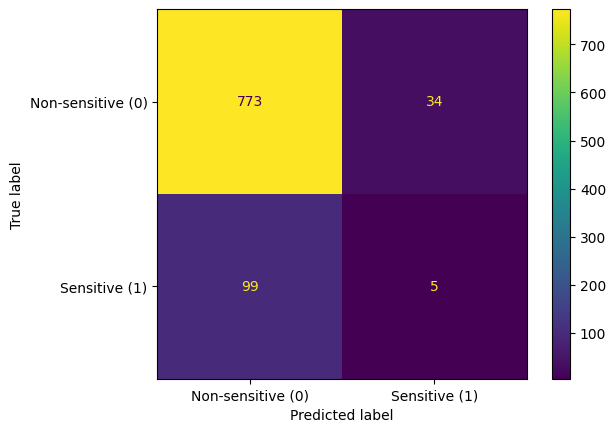

{'accuracy': 0.854006586169045, 'f1_score': 0.8236522243134563, 'balanced accuracy': 0.5029727861976933}


In [49]:
predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(samp, dev)
evaluation_summary("Mistral", scikit_true, scikit_pred)
get_metric_dict('Mistral', scikit_true, scikit_pred)

In [50]:
model_responses

{'175555_0': '\nAnswer:\nnon-sensitive.\n\nThe text does not contain any apparent sensitive personal information. It only',
 '175555_1': '\nAnswer:\nnon-sensitive.\n\nThe text appears to be discussing a business matter related to SDG',
 '175555_2': '\nAnswer:\nnon-sensitive.\n\nThe text does not contain any sensitive personal information. It is about',
 '175555_3': '\nAnswer:\nnon-sensitive.\n\nThe information provided in the text, which includes a name, company',
 '177838_0': '\nAnswer:\nnon-sensitive.\n\nThe text appears to be a standard meeting notice, and there is',
 '177838_1': '\nAnswer:\nnon-sensitive.',
 '177838_2': '\nAnswer:\nnon-sensitive.\n\nThe information provided in the text, which includes a name, job',
 '174374_0': '\nAnswer:\nnon-sensitive.\n\nThe text does not contain any sensitive personal information.',
 '174374_1': '\nAnswer:\nnon-sensitive.\n\nThe text does not contain any sensitive personal information. It appears to',
 '174374_2': '\nAnswer:\nnon-sensitive.\n\n

In [51]:
further_processing_required

{'115323_22': '\nAnswer:\nprofessional (The statement is a quote from a Governor, which is a professional context and does',
 '115323_25': '\nAnswer:\nprofessional.\n\nExplanation:\nThe text discusses actions taken in a professional',
 '115323_28': '\nAnswer:\nprofessional.\n\nExplanation:\nThe text is discussing a report related to the',
 '21257_2': '\nAnswer:\nprofessional.\n\nExplanation:\nThe text is discussing internal company policies and procedures',
 '219062_0': '\nAnswer:\nprofessional.\n\nExplanation:\nThe text appears to be discussing a legal or',
 '219062_2': '\nAnswer:\nprofessional.\n\nExplanation:\nThe text discusses a business matter involving a',
 '138049_0': "\nAnswer:\nThis text is professional. It discusses a FERC meeting and the speaker's comments on",
 '177818_0': '\nAnswer:\nprofessional.\n\nThe text is discussing potential incentives for management in a professional context.',
 '176608_1': '\nAnswer:\nprofessional (The text appears to be related to an Equal Empl

Post-processing of heavily split documents. Splitting paragraphs gives us many more documents.

In [63]:
def post_process_split_docs():
    clean_doc_id = {}
    ground_truths = []
    ite = -1
    for s in model_responses.keys(): #samp.doc_id():
        if s in further_processing_required.keys():
            continue

        if '_' in s:
            s = s[:s.find('_')]

        val = clean_doc_id.get(s, -1)
        ite += 1

        if val == -1:
            clean_doc_id[s] = scikit_pred[ite]
            ground_truths.append((sara_df[sara_df.doc_id == s].sensitivity).iloc[0])
            continue

        if (val == scikit_pred[ite] or val == 1):
            continue
        
        clean_doc_id[s] = scikit_pred[ite]

    #print(len(clean_doc_id.values()))
    values_array = np.array(list(clean_doc_id.values()))
    return values_array, ground_truths

values_array, ground_truths = post_process_split_docs()

Evaluation for: Mistral
                   precision    recall  f1-score   support

Non-sensitive (0)      0.871     0.859     0.865       142
    Sensitive (1)      0.130     0.143     0.136        21

         accuracy                          0.767       163
        macro avg      0.501     0.501     0.501       163
     weighted avg      0.776     0.767     0.771       163



Confusion matrix:


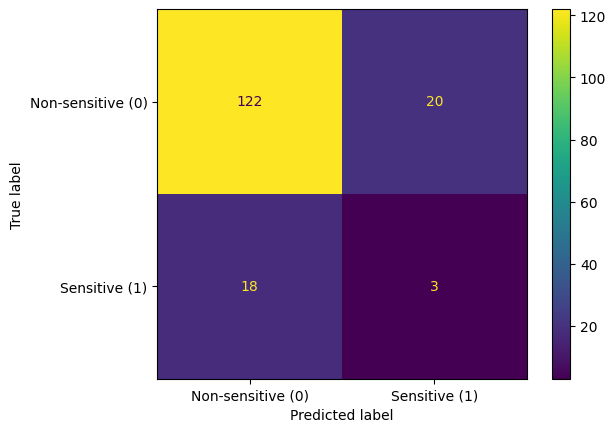

{'accuracy': 0.7668711656441718, 'f1_score': 0.7713428502489983, 'balanced accuracy': 0.5010060362173038}


In [64]:
evaluation_summary("Mistral", ground_truths, values_array)
get_metric_dict('Mistral', ground_truths, values_array)